# Малютин Павел, ИТПЗ РАН
 

In [1]:
import pandas as pd
import math 
import dask.dataframe as dd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from numba import jit, njit
from sklearn.linear_model import LinearRegression

# b-value calculating

In [2]:
'''чтение файла из директории проги
и устранение выбросов значений магнитуды округлением до 1 знака пз.'''
my_cat = pd.read_csv('./catalogues/DOUBLE_PREC_DD (2).csv', sep = ';') 
my_cat = my_cat.loc[my_cat.YEAR < 1985]
#my_cat = my_cat.loc[my_cat.latitude > 38.7751667]
#my_cat = my_cat.loc[my_cat.latitude < 38.8081667]
#my_cat = my_cat.loc[my_cat.longitude > -122.778]
#my_cat = my_cat.loc[my_cat.longitude < -122.733]
my_cat = my_cat.reset_index(drop = True)
my_cat.mag = round(my_cat.mag, 1)  
my_cat

,YEAR,MONTH,DAY,HOUR,MINUTE,SECOND,latitude,longitude,depth,EH1,EH2,AZ,EV,mag,ID
0,1984,1,1,1,19,11.317,36.08781,-120.22869,10.897,0.020,0.010,96,0.022,1.8,1109386
1,1984,1,1,1,58,2.420,36.87608,-120.90669,2.661,0.071,0.018,55,0.421,0.0,346
2,1984,1,1,1,59,27.124,36.87000,-120.90889,1.592,0.110,0.016,66,0.727,1.5,1109389
3,1984,1,1,2,28,4.240,37.51546,-118.75485,7.703,0.020,0.008,37,0.024,1.2,1109391
4,1984,1,1,3,8,58.044,40.57227,-124.55933,20.407,1.009,0.083,103,0.080,2.0,1109392
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21270,1984,12,31,21,44,17.740,38.79228,-122.77453,3.975,0.039,0.023,131,0.060,1.1,1124941
21271,1984,12,31,21,47,8.160,37.21852,-121.60970,3.779,0.003,0.003,46,0.007,0.7,36051
21272,1984,12,31,22,35,57.680,37.42411,-118.62705,6.234,0.014,0.010,20,0.027,1.1,36052
21273,1984,12,31,23,23,8.964,37.42794,-118.61264,12.437,0.024,0.014,11,0.030,1.6,1124943


In [3]:
'''from pathlib import Path  
filepath = Path('./results/my_cat.csv')
my_cat.to_csv(filepath)'''

"from pathlib import Path  \nfilepath = Path('./results/my_cat.csv')\nmy_cat.to_csv(filepath)"

Text(0.5, 0.98, 'График повторяемости землетрясений')

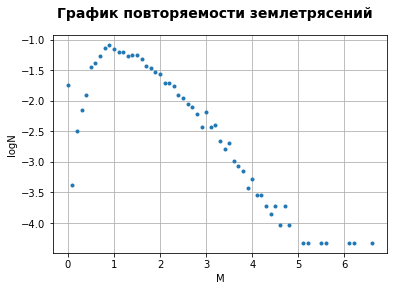

In [4]:
'''Следующий кусок вычисляет необходимые для построения графика повторяемости EQ параметры
а именно: N_tot - суммарное количество землетрясений
a - Series, состоящая из значений lg(N/N_tot) и соотвествующих магнитуд
и, собственно строит график ПЗ для оценки справедливости Г-Р.'''
N_tot = my_cat.shape
f = lambda x: math.log10(x/N_tot[0])
a = my_cat.mag.value_counts().apply(f)
a.plot(style='.')
plt.grid()
plt.xlabel("M")
plt.ylabel("logN")
plt.suptitle('График повторяемости землетрясений', 
             fontsize=14, fontweight='bold')
 # расчет b-value по формуле Aki
# mag - СТОЛБЕЦ С МАГНИТУДОЙ В ДАННОЙ csv


### Необходимо выбрать представительную магнитуду

In [5]:
M_0 = float(input())
my_cat = my_cat.loc[my_cat['mag'] > M_0]
my_cat = my_cat.reset_index(drop = True)
b_value = 1 / (my_cat['mag'].mean() - M_0) * (1/ math.log(10)) # расчет b-value по формуле Aki
print('\033[1m'+'b-value is:', b_value, ' ± ', b_value/math.sqrt(N_tot[0]))
N_tot = my_cat.shape

1.4
b-value is: 0.7020149560978459  ±  0.0048129525524274845


In [6]:
'''Вместо того, чтобы каждый раз перебирать для каждого заданного расстояния между
землетрясениями все возможные пары расстояний, в самом начале создается массив
с этими парами. Это существенно сокращает время выполнения программы'''
from random import random
array_of_dist = np.array([[random() for k in range(N_tot[0])] for i in range(N_tot[0])])

# Функция близости

In [7]:
d_f = 1.65

In [8]:
print("b-value is               ", round(b_value,3))
print("d_f is                   ", round(d_f,3))
print("Minimal magnitude M_0 is ", M_0)

b-value is                0.702
d_f is                    1.65
Minimal magnitude M_0 is  1.4


In [9]:
n_ = np.zeros((N_tot[0],N_tot[0])) #numpy-array - будущая матрица расстояний м/у событиями
'''нет смысла задавать inf, потому что потом все равно будут перемножения элементов матриц'''

'нет смысла задавать inf, потому что потом все равно будут перемножения элементов матриц'

In [10]:
year = np.array([my_cat.YEAR.to_numpy() for i in range(N_tot[0])])
month = np.array([(my_cat.MONTH.to_numpy())/12 for i in range(N_tot[0])])
day = np.array([my_cat.DAY.to_numpy()/365 for i in range(N_tot[0])])
hour = np.array([my_cat.HOUR.to_numpy()/8760 for i in range(N_tot[0])])
minute = np.array([my_cat.MINUTE.to_numpy()/525600 for i in range(N_tot[0])])
second = np.array([my_cat.SECOND.to_numpy()/31536000 for i in range(N_tot[0])])
TIME_IN_YEARS = year + month + day + hour + minute + second

In [11]:
delta_TIME_IN_YEARS = np.transpose(TIME_IN_YEARS) - TIME_IN_YEARS 

In [12]:
delta_TIME_IN_YEARS.shape
delta_TIME_IN_YEARS = np.tril(delta_TIME_IN_YEARS, k = 0)
delta_TIME_IN_YEARS[delta_TIME_IN_YEARS < 0] = abs(delta_TIME_IN_YEARS[np.where(delta_TIME_IN_YEARS < 0)])

In [13]:
mag = np.array([my_cat.mag.to_numpy() for i in range(N_tot[0])])
mag = np.tril(np.transpose(mag), k = 0)

In [14]:
delta_TIME_IN_YEARS

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [7.66047374e-05, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.08863743e-04, 1.32259005e-04, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [1.00107452e+00, 1.00099791e+00, 1.00086565e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.00137740e+00, 1.00130079e+00, 1.00116854e+00, ...,
        3.02881913e-04, 0.00000000e+00, 0.00000000e+00],
       [1.00140677e+00, 1.00133016e+00, 1.00119790e+00, ...,
        3.32248859e-04, 2.93669457e-05, 0.00000000e+00]])

In [15]:
n_ = math.pow(10,-b_value)*(np.multiply(np.multiply(delta_TIME_IN_YEARS,np.power(array_of_dist, d_f)),mag))

In [16]:
n_ = np.tril(n_, k=0)
n_[n_ == 0] = float('inf')
n_[n_ == np.nan] = float('inf')

In [17]:
np.save('n_', n_)

In [18]:
int(math.log10(min(n_[2]))*100)

-449

In [19]:
N = np.array([0.] * N_tot[0]) #Минимальное расстояние до соседа
D = np.array([0.] * N_tot[0]) #Номер события, до которого расстояние минимально (в перспективе - ближайший сосед)
#Поиск соответствующих расстояний и номеров
for i in range(1,len(n_)):
    D[i] = (math.log10(min(n_[i])))
    #N[i] = n_[:][i].index(min(n_[i][:]))
resultate = pd.DataFrame({'Closest_neigh':D, 'Index_o_CN':N})

In [20]:
resultate

,Closest_neigh,Index_o_CN
0,0.000000,0.0
1,-7.054375,0.0
2,-4.496637,0.0
3,-5.039478,0.0
4,-5.508774,0.0
...,...,...
7774,-6.654716,0.0
7775,-9.302126,0.0
7776,-8.876482,0.0
7777,-9.677502,0.0


In [21]:
resultate
from pathlib import Path  
filepath = Path('./results/nearest_dist_n_index.csv')
resultate.to_csv(filepath)

In [22]:
Dist_to_Nearest = resultate.Closest_neigh.value_counts(normalize=True)
from pathlib import Path  
filepath = Path('./results/nearest_dist_normalised_n_0.csv')
Dist_to_Nearest.to_csv(filepath)